In [8]:
from semantic_router.encoders import OpenAIEncoder
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator

from pinecone import Pinecone, ServerlessSpec
encoder = OpenAIEncoder(name='text-embedding-3-small')

In [9]:


spec = ServerlessSpec(
    cloud="aws",
    region="us-east-1",
)
index = pc.Index("cfa-research")
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'investment_research': {'vector_count': 2382}},
 'total_vector_count': 2382}

In [10]:
class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

In [11]:
from langchain_core.tools import tool
import requests
import re

@tool("fetch_arxiv")
def fetch_arxiv(arxiv_id: str):
    """Gets the abstract from an ArXiv paper given the arxiv ID. Useful for
    finding high-level context about a specific paper."""
    # get paper page in html
    res = requests.get(
        f"https://export.arxiv.org/abs/{arxiv_id}"
    )
    # search html for abstract
    abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
    )
    re_match = abstract_pattern.search(res.text)
    # return abstract text
    if re_match:
        return re_match.group(1)
    else:
        return "Abstract not found."
from langchain_core.tools import tool
from serpapi import GoogleSearch
import os

@tool("search_google")
def search_google(query: str):
    """Searches Google for articles and web pages related to the query.
    Returns a list of relevant search results with titles and snippets."""
    search = GoogleSearch({
        "q": query,
        
        "num": 5  # Number of results to return
    })
    results = search.get_dict()
    
    formatted_results = []
    for result in results.get("organic_results", []):
        formatted_results.append({
            "title": result.get("title"),
            "snippet": result.get("snippet"),
            "link": result.get("link")
        })
    return formatted_results

@tool("search_scholar")
def search_scholar(query: str):
    """Searches Google Scholar for academic papers related to the query.
    Returns a list of relevant academic papers with titles, authors, and abstracts."""
    search = GoogleSearch({
        "q": query,
        
        "engine": "google_scholar",
        "num": 5  # Number of results to return
    })
    
    results = search.get_dict()
    print(len(results))
    formatted_results = []
    for result in results.get("organic_results", []):
        formatted_results.append({
            "title": result.get("title"),
            "authors": result.get("authors", ""),
            "publication": result.get("publication_info", {}).get("summary", ""),
            "snippet": result.get("snippet"),
            "link": result.get("link"),
            "citations": result.get("inline_links", {}).get("cited_by", {}).get("total", 0)
        })
    return formatted_results

In [12]:
fetch_arxiv.invoke("2106.04561")
search_scholar.invoke("transformer architecture improvements")

7


[{'title': 'Transformer for graphs: An overview from architecture perspective',
  'authors': '',
  'publication': 'E Min, R Chen, Y Bian, T Xu, K Zhao, W Huang… - arXiv preprint arXiv …, 2022 - arxiv.org',
  'snippet': '… For example, on molpcba, we observe at most a 56% performance improvement compared with the vanilla Transformer. This observation confirms the effectiveness of graph-specific …',
  'link': 'https://arxiv.org/abs/2202.08455',
  'citations': 158},
 {'title': 'Transformer architecture and attention mechanisms in genome data analysis: a comprehensive review',
  'authors': '',
  'publication': 'SR Choi, M Lee - Biology, 2023 - mdpi.com',
  'snippet': '… The emergence and rapid development of deep learning, specifically transformer-based … advancements in the application of transformer architectures and attention mechanisms to …',
  'link': 'https://www.mdpi.com/2079-7737/12/7/1033',
  'citations': 44},
 {'title': 'The evolved transformer',
  'authors': '',
  'publication':

In [13]:
search_google.invoke("machine learning advances 2024")

[{'title': '10 top AI and machine learning trends for 2024',
  'snippet': '10 top AI and machine learning trends for 2024 · 1. Multimodal AI · 2. Agentic AI · 3. Open source AI · 4. Retrieval-augmented generation · 5.',
  'link': 'https://www.techtarget.com/searchenterpriseai/tip/9-top-AI-and-machine-learning-trends'},
 {'title': 'TOP 12 Machine Learning Trends To Impact Business in ...',
  'snippet': 'Discover the latest innovations in machine learning technology and go over various examples of how to use them for your product in 2024.',
  'link': 'https://mobidev.biz/blog/future-machine-learning-trends-impact-business'},
 {'title': 'Microsoft at ICML 2024: Innovations in machine learning',
  'snippet': '68 papers by Microsoft researchers and their collaborators have been accepted this year, including four chosen for oral presentations.',
  'link': 'https://www.microsoft.com/en-us/research/blog/microsoft-at-icml-2024-innovations-in-machine-learning/'},
 {'title': 'Advancements in Arti

In [14]:
@tool("final_answer")
def final_answer(
    introduction: str,
    research_steps: str,
    main_body: str,
    conclusion: str,
    sources: str
):
    """Returns a natural language response to the user in the form of a research
    report. There are several sections to this report, those are:
    - `introduction`: a short paragraph introducing the user's question and the
    topic we are researching.
    - `research_steps`: a few bullet points explaining the steps that were taken
    to research your report.
    - `main_body`: this is where the bulk of high quality and concise
    information that answers the user's question belongs. It is 3-4 paragraphs
    long in length.
    - `conclusion`: this is a short single paragraph conclusion providing a
    concise but sophisticated view on what was found.
    - `sources`: a bulletpoint list provided detailed sources for all information
    referenced during the research process
    """
    print(f"""
    introduction: {introduction}
    research_steps: {research_steps}
    main_body: {main_body}
    conclusion: {conclusion}
    sources: {sources}
    """)
    return ""

In [15]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """You are the oracle, the great AI decision maker.
Given the user's query you must decide what to do with it based on the
list of tools provided to you.

If you see that a tool has been used (in the scratchpad) with a particular
query, do NOT use that same tool with the same query again. Also, do NOT use
any tool more than twice (ie, if the tool appears in the scratchpad twice, do
not use it again).

You should aim to collect information from a diverse range of sources before
providing the answer to the user. Once you have collected plenty of information
to answer the user's question (stored in the scratchpad) use the final_answer
tool."""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("assistant", "scratchpad: {scratchpad}"),
])

In [37]:
from langchain_core.messages import ToolCall, ToolMessage
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    openai_api_key=os.environ["OPENAI_API_KEY"],
    temperature=0
)

tools=[
    fetch_arxiv,
    search_google,
    search_scholar,
    final_answer
]
tool_str_to_func = {
    "fetch_arxiv": fetch_arxiv,
    "search_google": search_google,
    "search_scholar": search_scholar,
    "final_answer": final_answer    
}

# define a function to transform intermediate_steps from list
# of AgentAction to scratchpad string
def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":
            # this was the ToolExecution
            research_steps.append(
                f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
    return "\n---\n".join(research_steps)

oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(
            intermediate_steps=x["intermediate_steps"]
        ),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="any")
)

In [17]:
inputs = {
    "input": "The Economics of Private Equity: A Critical Review",
    "chat_history": [],
    "intermediate_steps": [],
}
out = oracle.invoke(inputs)

In [18]:
for i in out.tool_calls:
    print(i["name"])

search_google
search_scholar


In [19]:
def run_oracle(state: list):
    print("run_oracle")
    print(f"intermediate_steps: {state['intermediate_steps']}")
    out = oracle.invoke(state)
    tool_name = out.tool_calls[0]["name"]
    tool_args = out.tool_calls[0]["args"]
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log="TBD"
    )
    return {
        "intermediate_steps": [action_out]
    }

def router(state: list):
    # return the tool name to use
    if isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool
    else:
        # if we output bad format go to final answer
        print("Router invalid format")
        return "final_answer"
    
def run_tool(state: list):
    # use this as helper function so we repeat less code
    print("run_tool for" + state["intermediate_steps"][-1].tool)
    for i in state["intermediate_steps"]:
        print(f"{i.tool}: {i.tool_input}")
        print(f"Output: {i.log}")
    tool_name = state["intermediate_steps"][-1].tool
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"{tool_name}.invoke(input={tool_args})")
    # run tool
    out = tool_str_to_func[tool_name].invoke(input=tool_args)
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )
    return {"intermediate_steps": [action_out]}

In [21]:
from langgraph.graph import StateGraph, END
from langchain.agents import AgentExecutor, create_react_agent, load_tools
graph = StateGraph(AgentState)
tool_str_to_func = {
    "fetch_arxiv": fetch_arxiv,
    "search_google": search_google,
    "search_scholar": search_scholar,
    "final_answer": final_answer    
}
graph.add_node("oracle", run_oracle)
graph.add_node("fetch_arxiv", run_tool)
graph.add_node("search_google", run_tool)
graph.add_node("search_scholar", run_tool)
graph.add_node("arxiv", load_tools(["arxiv"])[0])
graph.add_node("final_answer", run_tool)

graph.set_entry_point("oracle")

graph.add_conditional_edges(
    source="oracle",  # where in graph to start
    path=router,  # function to determine which node is called
)

# create edges from each tool back to the oracle
for tool_obj in tools:
    if tool_obj.name != "final_answer":
        graph.add_edge(tool_obj.name, "oracle")

# if anything goes to final answer, it must then move to END
graph.add_edge("final_answer", END)

runnable = graph.compile()

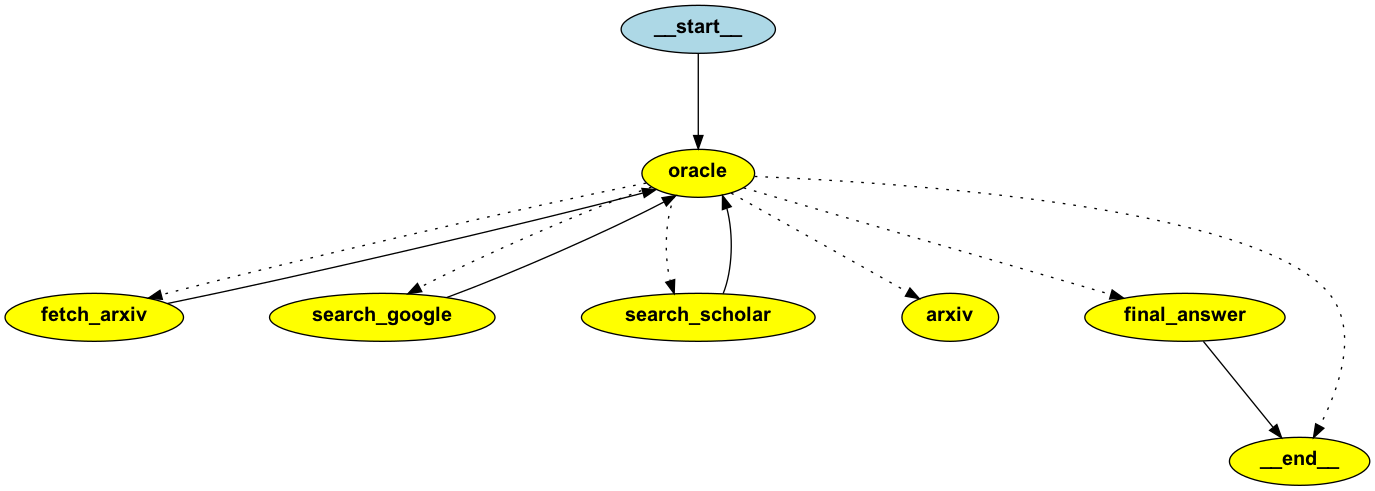

In [22]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())

In [ ]:
out = runnable.invoke({
    "input": "The Economics of Private Equity: A Critical Review",
    "chat_history": [],
})

In [ ]:
def build_report(output: dict):
    output = output.get("intermediate_steps")[-1].tool_input
    research_steps = output["research_steps"]
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    sources = output["sources"]
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return f"""
INTRODUCTION
------------
{output["introduction"]}

RESEARCH STEPS
--------------
{research_steps}

REPORT
------
{output["main_body"]}

CONCLUSION
----------
{output["conclusion"]}

SOURCES
-------
{sources}
"""

In [ ]:
build_report(out)

In [ ]:
from langchain import hub
from langchain.agents import AgentExecutor, create_react_agent, load_tools
from langchain_openai import ChatOpenAI
!source /Users/saisuryamadhav/Documents/export_api_keys.sh
from dotenv import load_dotenv
load_dotenv()
import os

llm = ChatOpenAI(temperature=0.0)
tools = load_tools(
    ["arxiv"],
)
print(os.getenv("LANGCHAIN_API_KEY"))
prompt = hub.pull("hwchase17/react")

agent = create_react_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)



In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()
llm.invoke("Hello, world!")

Published: 2020-12-28
Title: Micro-expression spotting: A new benchmark
Authors: Thuong-Khanh Tran, Quang-Nhat Vo, Xiaopeng Hong, Xiaobai Li, Guoying Zhao
Summary: Micro-expressions (MEs) are brief and involuntary facial expressions that
occur when people are trying to hide their true feelings or conceal their
emotions. Based on psychology research, MEs play an important role in
understanding genuine emotions, which leads to many potential applications.
Therefore, ME analysis has become an attractive topic for various research
areas, such as psychology, law enforcement, and psychotherapy. In the computer
vision field, the study of MEs can be divided into two main tasks, spotting and
recognition, which are used to identify positions of MEs in videos and
determine the emotion category of the detected MEs, respectively. Recently,
although much research has been done, no fully automatic system for analyzing
MEs has yet been constructed on a practical level for two main reasons: most of
the

In [33]:

@tool("fetch_arxiv")
def fetch_arxiv(query: str):
    """Fetches academic papers related to the query from arXiv.
    Returns a list of relevant academic papers with titles, authors, and abstracts."""
    url = f"http://export.arxiv.org/api/query?search_query=all:{query}&start=0&max_results=5"
    response = requests.get(url)
    print(response.text)
    papers = re.findall(r"<entry>(.*?)</entry>", response.text, re.DOTALL)
    
    formatted_papers = []
    for paper in papers:
        title = re.search(r"<title>(.*?)</title>", paper).group(1)
        authors = re.findall(r"<author><name>(.*?)</name>", paper)
        abstract = re.search(r"<summary>(.*?)</summary>", paper).group(1)
        formatted_papers.append({
            "title": title,
            "authors": authors,
            "abstract": abstract
        })
    return formatted_papers

In [34]:
fetch_arxiv.invoke("transformer architecture improvements")

<?xml version="1.0" encoding="UTF-8"?>
<feed xmlns="http://www.w3.org/2005/Atom">
  <link href="http://arxiv.org/api/query?search_query%3Dall%3Atransformer%20architecture%20improvements%26id_list%3D%26start%3D0%26max_results%3D5" rel="self" type="application/atom+xml"/>
  <title type="html">ArXiv Query: search_query=all:transformer architecture improvements&amp;id_list=&amp;start=0&amp;max_results=5</title>
  <id>http://arxiv.org/api/o4p52Y+ev8fbkFWZsqUBOb0RaSw</id>
  <updated>2024-11-14T00:00:00-05:00</updated>
  <opensearch:totalResults xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">462924</opensearch:totalResults>
  <opensearch:startIndex xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">0</opensearch:startIndex>
  <opensearch:itemsPerPage xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">5</opensearch:itemsPerPage>
  <entry>
    <id>http://arxiv.org/abs/2311.12678v1</id>
    <updated>2023-11-21T15:36:20Z</updated>
    <published>2023-11-21T15:36:20Z</published>

AttributeError: 'NoneType' object has no attribute 'group'

In [36]:
import requests
from xml.etree import ElementTree
from urllib.parse import quote_plus
from typing import List, Dict
from functools import wraps
from datetime import datetime

def log_decorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = datetime.now()
        print(f"[{start_time}] Starting {func.__name__} with args: {args}")
        try:
            result = func(*args, **kwargs)
            print(f"[{datetime.now()}] Successfully completed {func.__name__}")
            return result
        except Exception as e:
            print(f"[{datetime.now()}] Error in {func.__name__}: {str(e)}")
            raise
    return wrapper

@log_decorator
def fetch_arxiv(query: str) -> List[Dict[str, any]]:
    """Fetches academic papers related to the query from arXiv.
    Returns a list of relevant academic papers with titles, authors, and abstracts.
    
    Args:
        query (str): Search query for papers
        
    Returns:
        List[Dict]: List of papers with title, authors, abstract, and url
    """
    try:
        # Prepare URL with sanitized query
        sanitized_query = quote_plus(query.strip())
        url = f"http://export.arxiv.org/api/query?search_query=all:{sanitized_query}&start=0&max_results=5"
        
        # Make request
        response = requests.get(url, timeout=10)
        response.raise_for_status()

        # Parse XML
        root = ElementTree.fromstring(response.content)
        formatted_papers = []

        # Process each entry
        for entry in root.findall('{http://www.w3.org/2005/Atom}entry'):
            try:
                # Extract paper details
                title = entry.find('{http://www.w3.org/2005/Atom}title').text.strip()
                abstract = entry.find('{http://www.w3.org/2005/Atom}summary').text.strip()
                authors = [author.find('{http://www.w3.org/2005/Atom}name').text.strip()
                          for author in entry.findall('{http://www.w3.org/2005/Atom}author')]
                
                # Get paper URL
                url = next(
                    (link.get('href') for link in entry.findall('{http://www.w3.org/2005/Atom}link') 
                     if link.get('rel') == 'alternate'),
                    None
                )
                
                formatted_papers.append({
                    "title": title,
                    "authors": authors,
                    "abstract": abstract,
                    "url": url
                })
            except AttributeError as e:
                print(f"[{datetime.now()}] Skipping paper due to missing data: {str(e)}")
                continue

        return formatted_papers

    except Exception as e:
        print(f"[{datetime.now()}] Error fetching papers: {str(e)}")
        return []

if __name__ == "__main__":
    papers = fetch_arxiv("transformer architecture improvements")
    for paper in papers:
        print("\nTitle:", paper['title'])
        print("Authors:", ", ".join(paper['authors']))
        print("URL:", paper['url'])
        print("Abstract:", paper['abstract'][:200] + "...")

2024-11-14 04:06:06,155 - INFO - Fetching papers for query: transformer architecture improvements
2024-11-14 04:06:06,456 - INFO - Successfully fetched 5 papers


[{'title': 'Interpretation of the Transformer and Improvement of the Extractor', 'authors': ['Zhe Chen'], 'abstract': 'It has been over six years since the Transformer architecture was put\nforward. Surprisingly, the vanilla Transformer architecture is still widely\nused today. One reason is that the lack of deep understanding and comprehensive\ninterpretation of the Transformer architecture makes it more challenging to\nimprove the Transformer architecture. In this paper, we first interpret the\nTransformer architecture comprehensively in plain words based on our\nunderstanding and experiences. The interpretations are further proved and\nverified. These interpretations also cover the Extractor, a family of drop-in\nreplacements for the multi-head self-attention in the Transformer architecture.\nThen, we propose an improvement on a type of the Extractor that outperforms the\nself-attention, without introducing additional trainable parameters.\nExperimental results demonstrate that the 